In [13]:
# 1. Import thư viện
from pyexpat import model
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns   
# 2. Đọc dữ liệu
df = pd.read_csv(r"C:\Users\tranq\Downloads\weather_cleaned.csv")

In [14]:
# 2. Chọn đặc trưng
features = [
    'province', 'year', 'month', 'day', 'wind', 'humidi', 'cloud',
    'rain_1', 'rain_2', 'rain_3', 'rain_7',
    'rain_mean_3d', 'rain_mean_7d', 'rain_mean_10d', 'rain_mean_14d',
    'avg_temp', 'temp_range', 'season', 'wind_d', 'region'
]
X = df[features]
y = df['rain']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# log1p:
y_log = np.log1p(y)

# Chia dữ liệu
X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# Tính sample_weight
sample_weight = np.where(np.expm1(y_train_log) > 10, 2.0, 1.0)

# Khôi phục giá trị thực sau log1p để đánh giá 
y_test_mm = np.expm1(y_test_log)

In [15]:
import time

# Mô hình XGBoost
# Khởi tạo 
model = XGBRegressor(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.5,
    random_state=42
)
# Huấn luyện mô hình
model.fit(X_train, y_train_log, sample_weight=sample_weight)

# Dự đoán trên tập test
start = time.time()
y_pred_log_xgb = model.predict(X_test)
inference_time = time.time() - start

# Chuyển dự đoán về đơn vị mm 
y_pred_mm_xgb = np.expm1(y_pred_log_xgb)
y_test_mm_xgb = np.expm1(y_test_log)


# Chỉ số đánh giá 
rmse_xgb = mean_squared_error(y_test_mm, y_pred_mm_xgb)
r2_xgb = r2_score(y_test_mm, y_pred_mm_xgb)

# Dự đoán tập train để so sánh overfit
y_train_pred_log = model.predict(X_train)
y_train_pred_mm = np.expm1(y_train_pred_log)
train_rmse = mean_squared_error(np.expm1(y_train_log), y_train_pred_mm)
train_r2 = r2_score(np.expm1(y_train_log), y_train_pred_mm)

# In kết quả
print(f" XGBoost RMSE: {rmse_xgb:.2f} mm | R²: {r2_xgb:.4f}")
print(f" Train RMSE: {train_rmse:.2f} | Train R²: {train_r2:.4f}")
print(f" Inference time: {inference_time:.4f} giây cho {len(X_test)} mẫu (~{inference_time/len(X_test):.6f} giây/mẫu)")

# So sánh thực tế vs dự đoán
print("\n So sánh thực tế vs dự đoán (10 dòng đầu):")
for true_val, pred_val in zip(y_test_mm[:10], y_pred_mm_xgb[:10]):
    print(f"Thực tế: {true_val:6.2f} mm | Dự đoán: {pred_val:6.2f} mm")


 XGBoost RMSE: 10.94 mm | R²: 0.9317
 Train RMSE: 8.87 | Train R²: 0.9483
 Inference time: 0.0120 giây cho 32502 mẫu (~0.000000 giây/mẫu)

 So sánh thực tế vs dự đoán (10 dòng đầu):
Thực tế:   1.70 mm | Dự đoán:   1.73 mm
Thực tế:   0.00 mm | Dự đoán:   0.04 mm
Thực tế:  37.00 mm | Dự đoán:  39.34 mm
Thực tế:   1.20 mm | Dự đoán:   1.13 mm
Thực tế:   0.30 mm | Dự đoán:   0.44 mm
Thực tế:  15.10 mm | Dự đoán:  14.94 mm
Thực tế:   2.40 mm | Dự đoán:   2.14 mm
Thực tế:   0.00 mm | Dự đoán:  -0.00 mm
Thực tế:   0.20 mm | Dự đoán:   0.14 mm
Thực tế:   6.50 mm | Dự đoán:   6.36 mm


In [16]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import time

# Mô hình Random Forest
# Khởi tạo mô hình 
rf_model = RandomForestRegressor(
    n_estimators=500,
    max_depth=7,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

# Huấn luyện mô hình
rf_model.fit(X_train, y_train_log, sample_weight=sample_weight)

# Dự đoán trên tập test
start_time = time.time()
y_pred_log_rf = rf_model.predict(X_test)
inference_time = time.time() - start_time

# Chuyển đổi dự đoán về đơn vị mm
y_pred_mm_rf = np.expm1(y_pred_log_rf)
y_test_mm_rf = np.expm1(y_test_log)

# Đánh giá & hiển thị 
rmse_rf = mean_squared_error(y_test_mm_rf, y_pred_mm_rf)**0.5
r2_rf = r2_score(y_test_mm_rf, y_pred_mm_rf)

# Dự đoán tập train để so sánh overfit
y_train_pred = np.expm1(rf_model.predict(X_train))
y_train_true = np.expm1(y_train_log)
train_rmse_rf = mean_squared_error(y_train_true, y_train_pred)**0.5
train_r2_rf = r2_score(y_train_true, y_train_pred)

# In kết quả
print(f" Random Forest RMSE: {rmse_rf:.2f} mm | R²: {r2_rf:.4f}")
print(f" Train RMSE: {train_rmse_rf:.2f} | R²: {train_r2_rf:.4f} ")
print(f" Inference time: {inference_time:.4f} giây cho {len(X_test)} mẫu (~{inference_time/len(X_test):.6f} giây/mẫu)")

# So sánh thực tế vs dự đoán
print("\n So sánh thực tế vs dự đoán (10 dòng đầu):")
for i, (true_val, pred_val) in enumerate(zip(y_test_mm[:10], y_pred_mm_rf[:10])):
    print(f"Thực tế: {true_val:6.2f} mm | Dự đoán: {pred_val:6.2f} mm")


 Random Forest RMSE: 5.21 mm | R²: 0.8309
 Train RMSE: 5.55 | R²: 0.8206 
 Inference time: 0.1238 giây cho 32502 mẫu (~0.000004 giây/mẫu)

 So sánh thực tế vs dự đoán (10 dòng đầu):
Thực tế:   1.70 mm | Dự đoán:   2.29 mm
Thực tế:   0.00 mm | Dự đoán:   0.00 mm
Thực tế:  37.00 mm | Dự đoán:  28.64 mm
Thực tế:   1.20 mm | Dự đoán:   1.20 mm
Thực tế:   0.30 mm | Dự đoán:   0.20 mm
Thực tế:  15.10 mm | Dự đoán:  13.18 mm
Thực tế:   2.40 mm | Dự đoán:   2.30 mm
Thực tế:   0.00 mm | Dự đoán:   0.00 mm
Thực tế:   0.20 mm | Dự đoán:   0.29 mm
Thực tế:   6.50 mm | Dự đoán:   6.24 mm


In [17]:
import joblib
# Giả sử bạn có mô hình XGBoost đã huấn luyện tên là model
joblib.dump(model, "rain_model_xgb.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

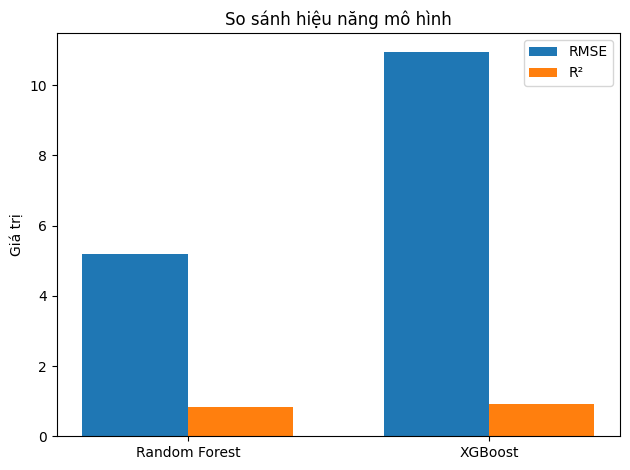

In [18]:

# Lưu lại RMSE và R2 test cho từng mô hình
rmse_rf = rmse_rf
r2_rf = r2_rf
rmse_xgb = rmse_xgb
r2_xgb = r2_xgb
      

import matplotlib.pyplot as plt
import numpy as np

models = ["Random Forest", "XGBoost"]
rmse_values = [rmse_rf, rmse_xgb]
r2_values = [r2_rf, r2_xgb]

x = np.arange(len(models))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, rmse_values, width, label="RMSE")
ax.bar(x + width/2, r2_values, width, label="R²")

ax.set_ylabel("Giá trị")
ax.set_title("So sánh hiệu năng mô hình")
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()
plt.tight_layout()
plt.show()
